In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plato.stars import classify_stars
from plato.visualisation import FigureProcessor, set_plot_defaults

In [2]:
field = "LOPS2"

In [3]:
set_plot_defaults()

figure_directory = f"../figures/04_stellar_sample/{field}"
save = False

In [4]:
data = pd.read_csv(f"../data/processed/{field}_targets.csv")
data = classify_stars(
    data,
    overwrite=True,
    return_galactic_quantities=True,
)  # add U, V, W, UW, R, Z columns

# filter for FGK stars and remove 0 mass or radius
data = data[data["Stellar Type"] == "FGK"]
data = data[(data["Radius"] > 0) & (data["Mass"] > 0)]

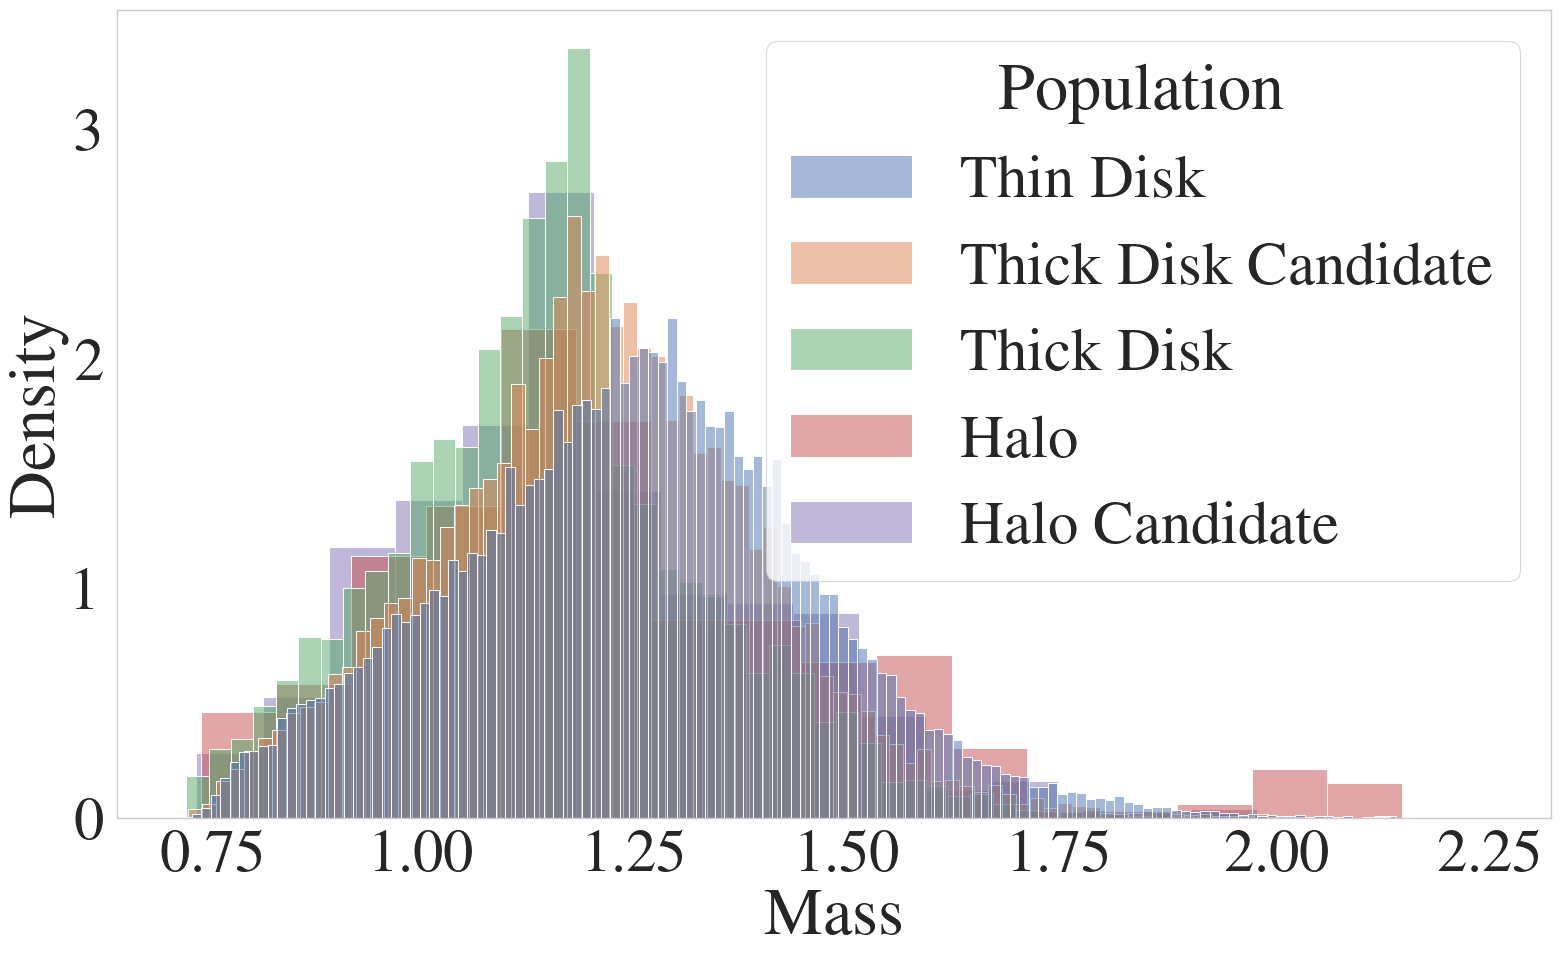

In [49]:
mass_histogram = sns.histplot(
    data=data,
    x="Mass",
    hue="Population",
    stat="density",
    common_norm=False,
    common_bins=False,
)

FigureProcessor(mass_histogram).save(
    f"histogram_masses.pdf",
    figure_directory=figure_directory,
    save=save,
)

<Axes: xlabel='Radius', ylabel='Density'>

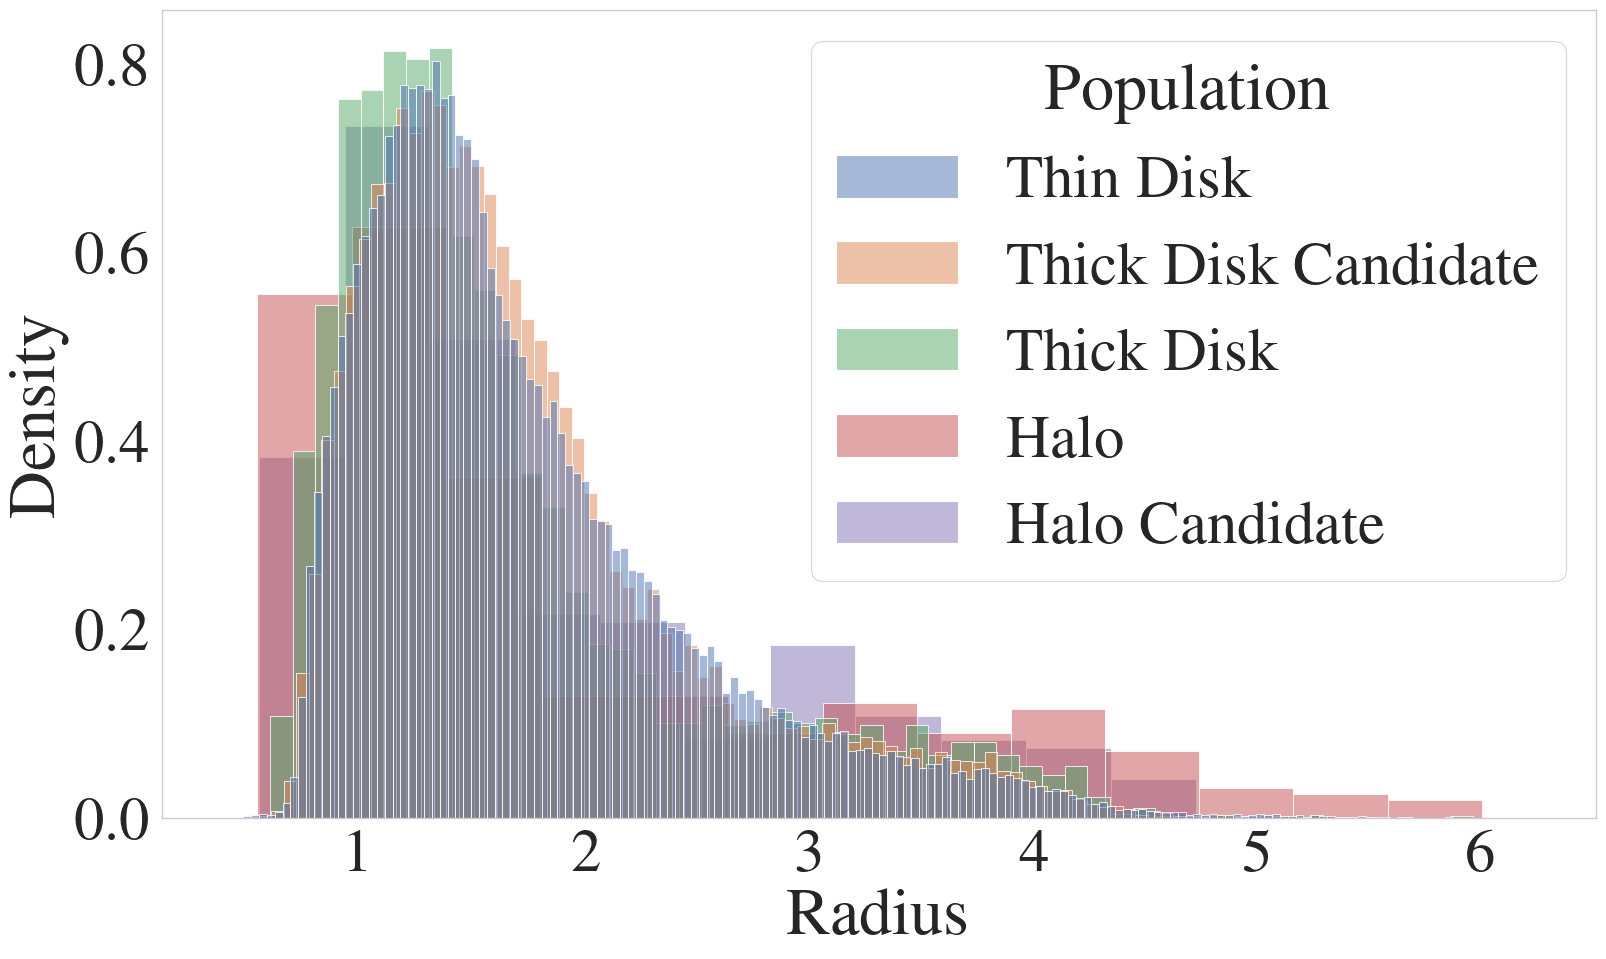

In [64]:
sns.histplot(
    data=data,
    x="Radius",
    hue="Population",
    stat="density",
    common_norm=False,
    common_bins=False,
)

<Axes: xlabel='gaiaV', ylabel='Density'>

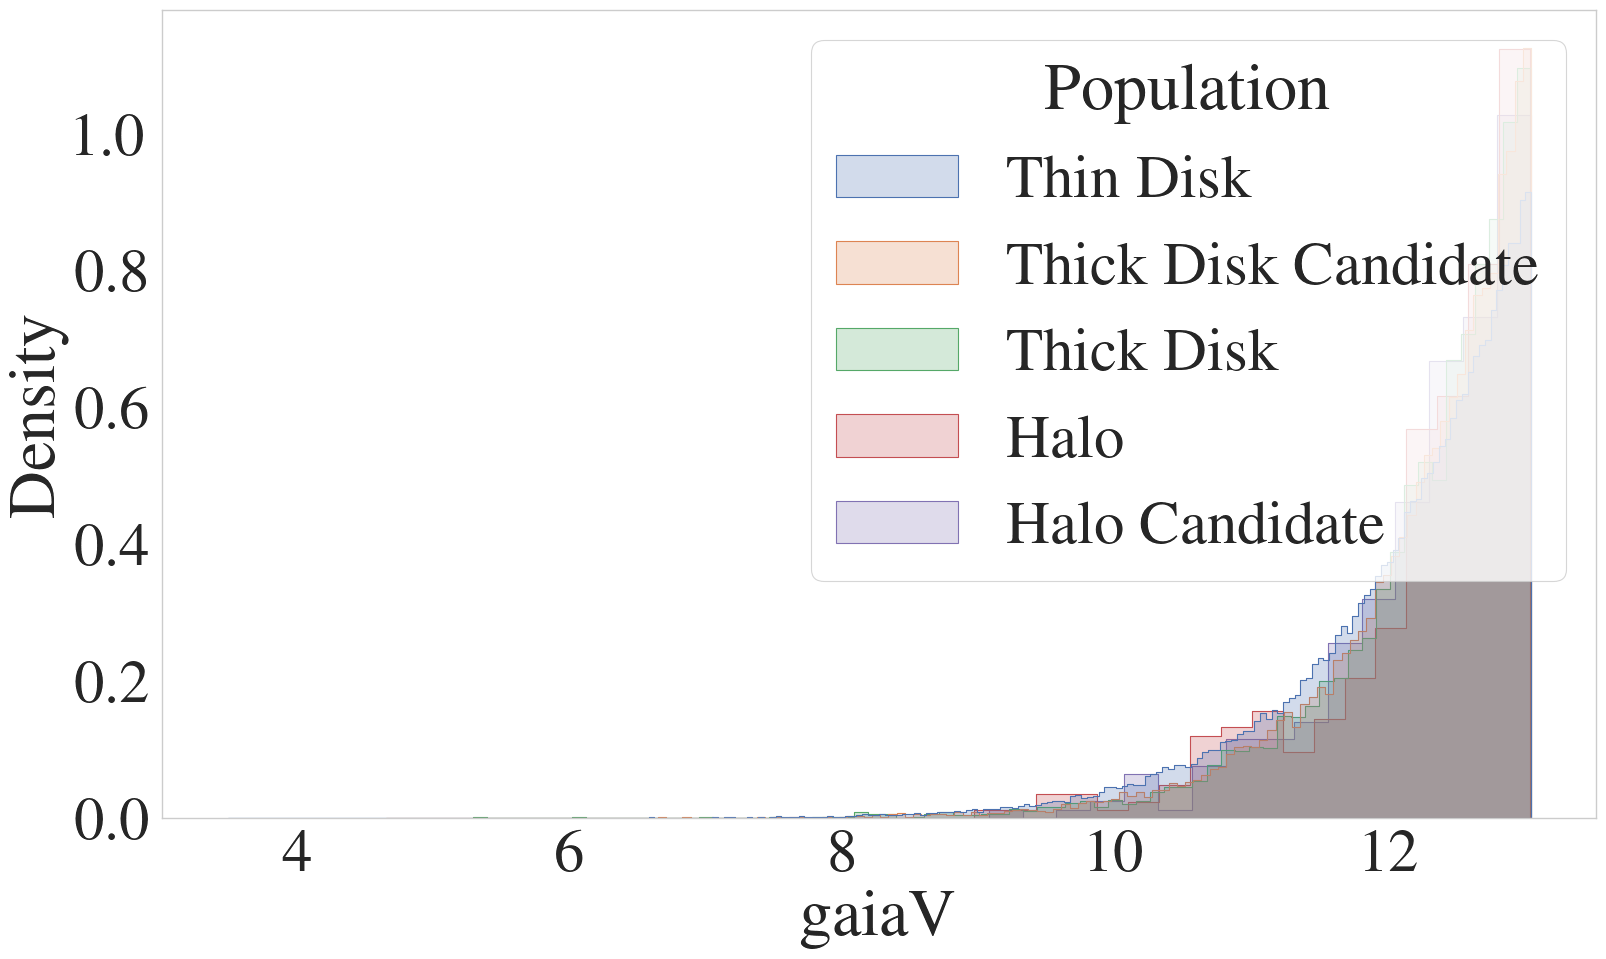

In [51]:
sns.histplot(
    data=data,
    x="gaiaV",
    hue="Population",
    stat="density",
    common_norm=False,
    element="step",
    common_bins=False,
)

<Axes: xlabel='[Fe/H]_apogee', ylabel='Density'>

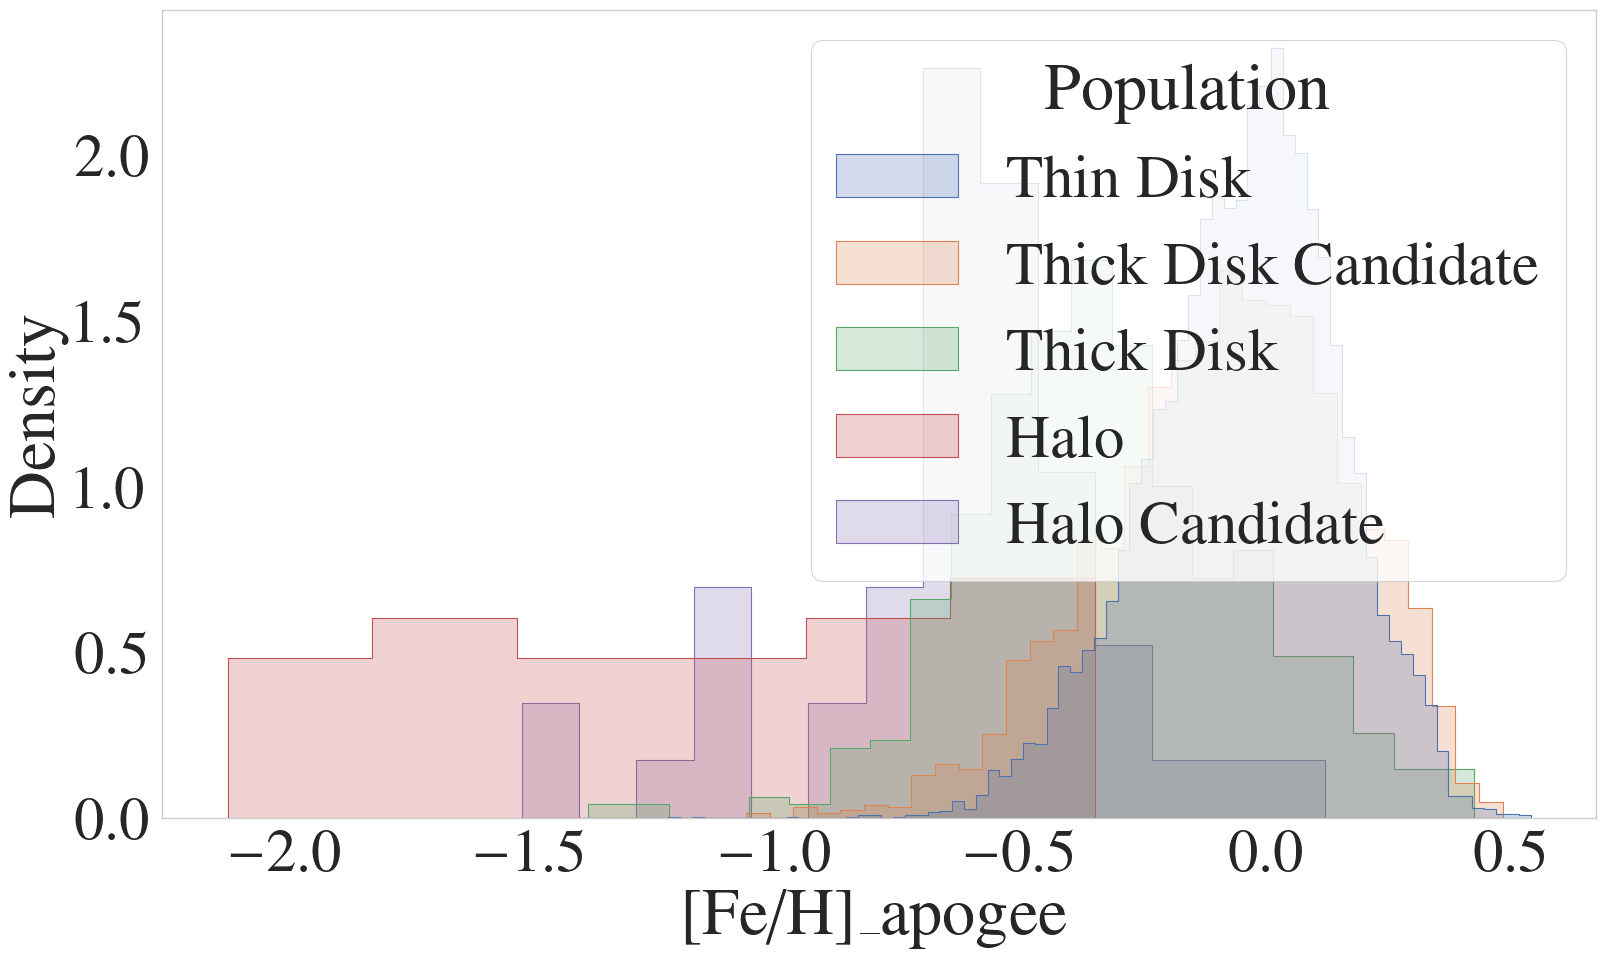

In [52]:
sns.histplot(
    data=data,
    x="[Fe/H]_apogee",
    hue="Population",
    stat="density",
    common_norm=False,
    element="step",
    common_bins=False,
)

In [53]:
# group by population and calculate mean and std of [Fe/H]
feh_stats = data.groupby("Population")["[Fe/H]"].agg(["mean", "median", "std"])
print(feh_stats)

                          mean  median       std
Population                                      
Halo                 -1.250326  -1.209  0.706606
Halo Candidate       -0.735736  -0.640  0.540376
Thick Disk           -0.436558  -0.330  0.673961
Thick Disk Candidate -0.120223  -0.070  0.451225
Thin Disk            -0.128278  -0.084  0.424270


<Axes: xlabel='[alpha/M]_apogee', ylabel='Density'>

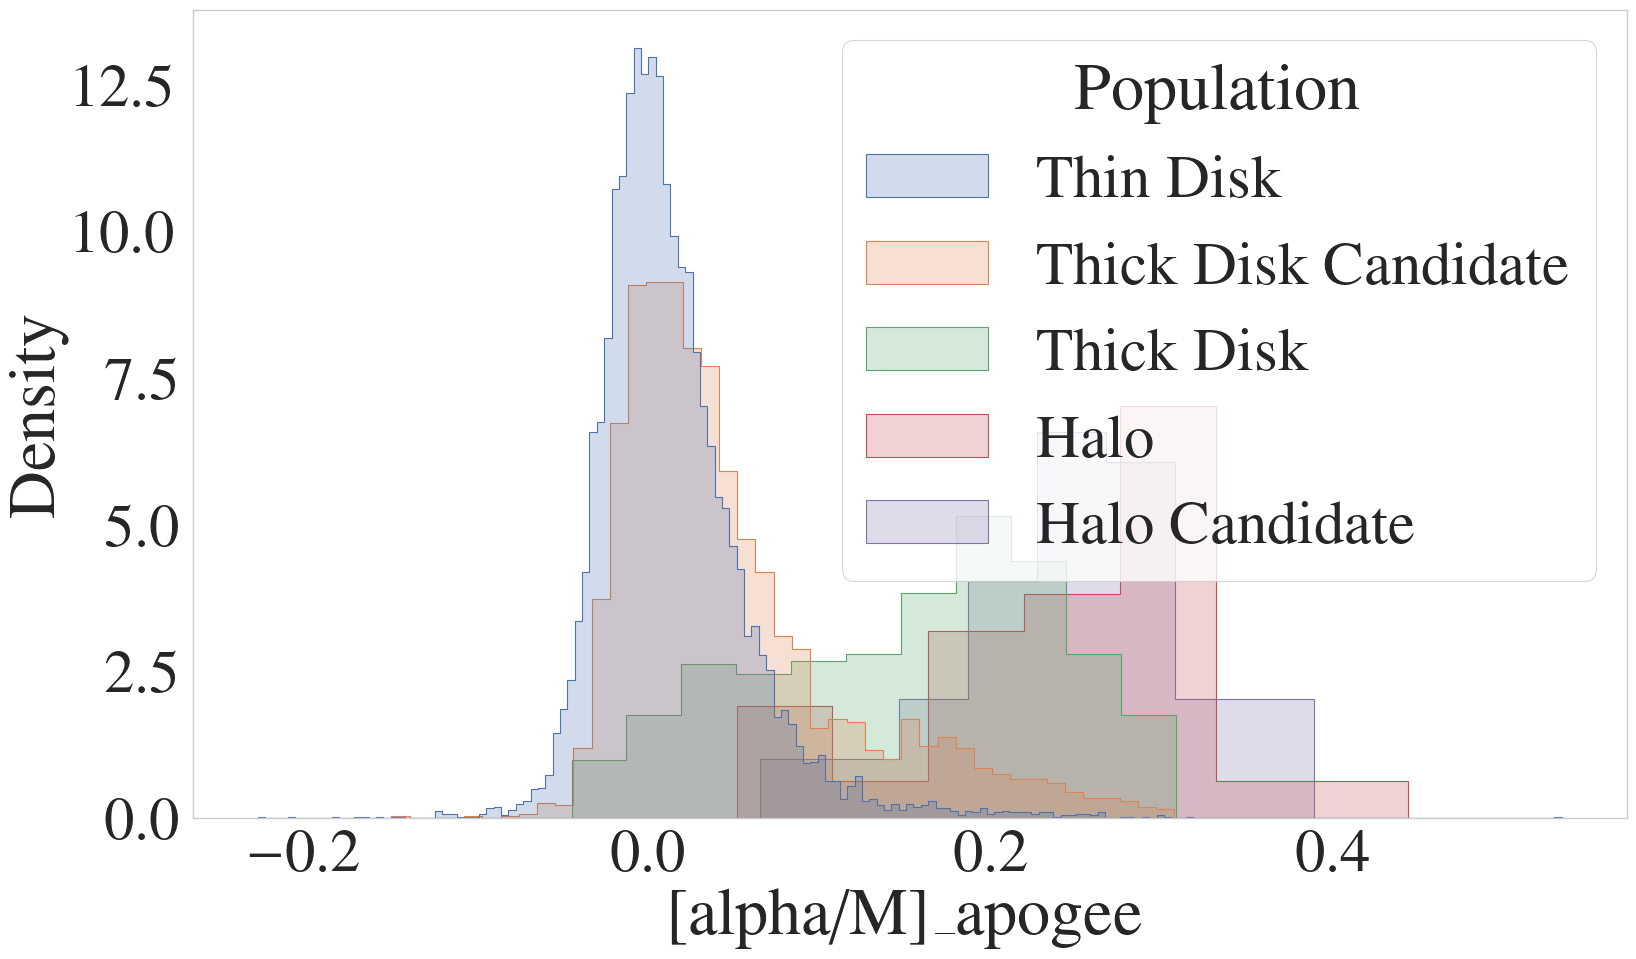

In [54]:
# histplot alpha/Fe
sns.histplot(
    data=data,
    x="[alpha/M]_apogee",
    hue="Population",
    stat="density",
    common_norm=False,
    element="step",
    common_bins=False,
)

In [55]:
# group by population and calculate mean and std of [Fe/H]
feh_stats = data.groupby("Population")["[alpha/Fe]"].agg(["mean", "median", "std"])
print(feh_stats)

                          mean  median       std
Population                                      
Halo                  0.110149   0.120  0.312543
Halo Candidate        0.277273   0.265  0.185508
Thick Disk            0.156346   0.140  0.193596
Thick Disk Candidate  0.095432   0.080  0.175357
Thin Disk             0.137474   0.120  0.186663


<Axes: xlabel='[Fe/H]_apogee', ylabel='[alpha/M]_apogee'>

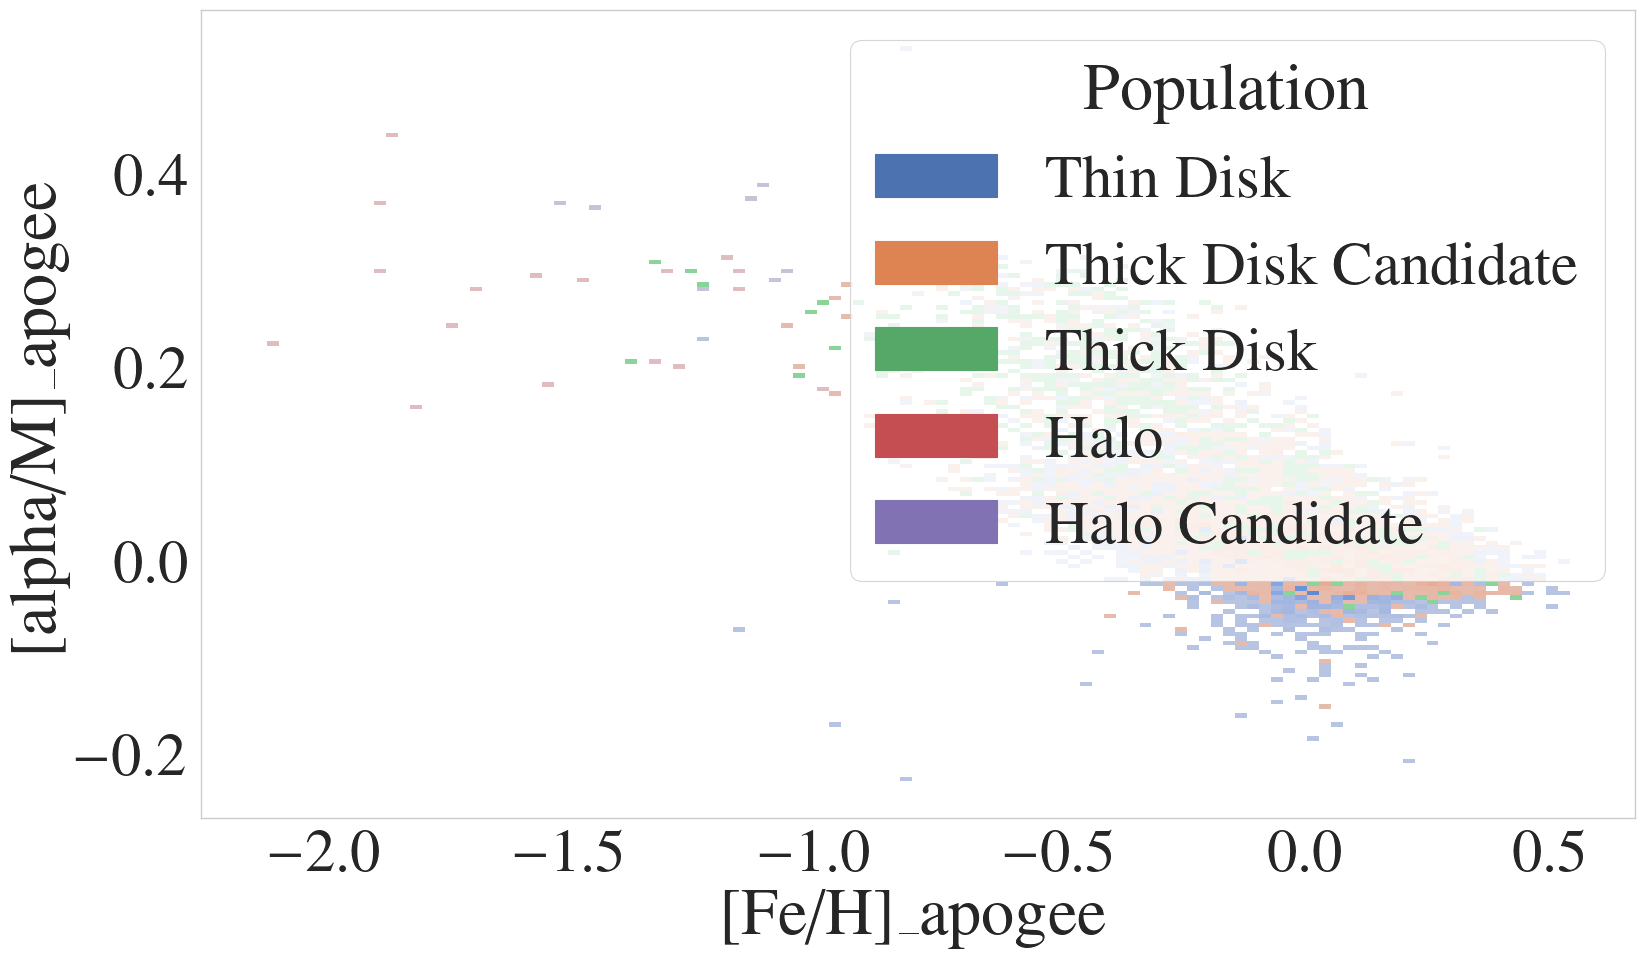

In [56]:
# plot alpha vs [Fe/H] as histogram
sns.histplot(
    data=data,
    x="[Fe/H]_apogee",
    y="[alpha/M]_apogee",
    stat="density",
    hue="Population",
)

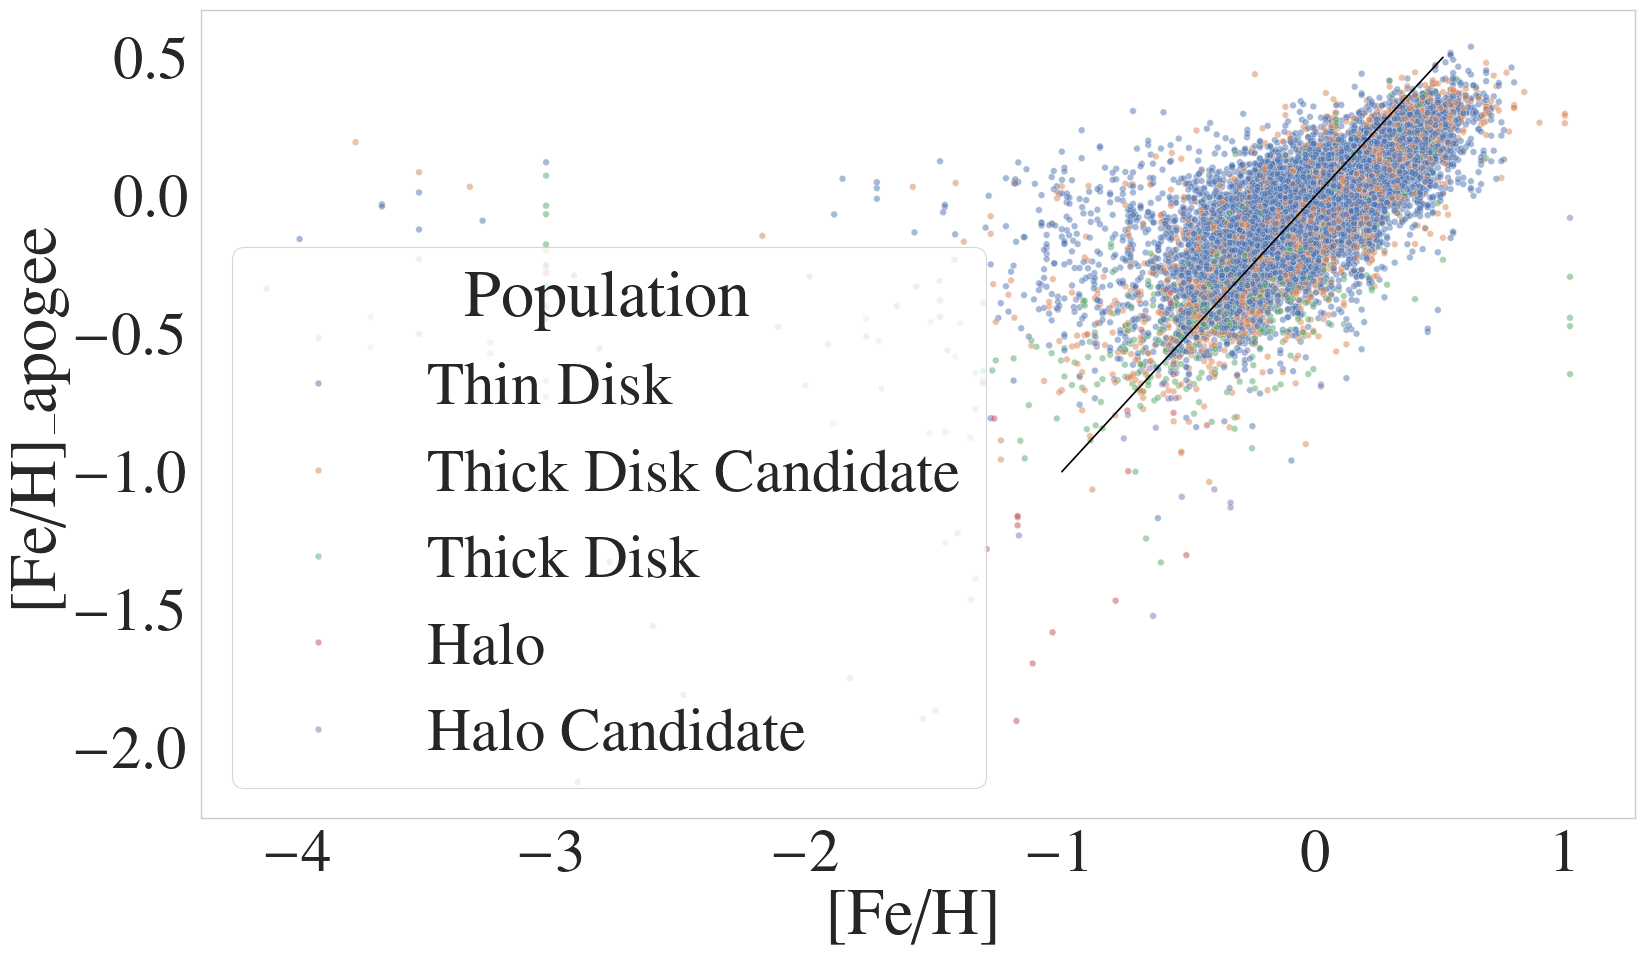

In [57]:
sns.scatterplot(
    data=data,
    x="[Fe/H]",
    y="[Fe/H]_apogee",
    hue="Population",
    alpha=0.5,
)
plt.plot([-1, 0.5], [-1, 0.5], color="black")

<Axes: xlabel='[Fe/H]_apogee', ylabel='[alpha/M]_apogee'>

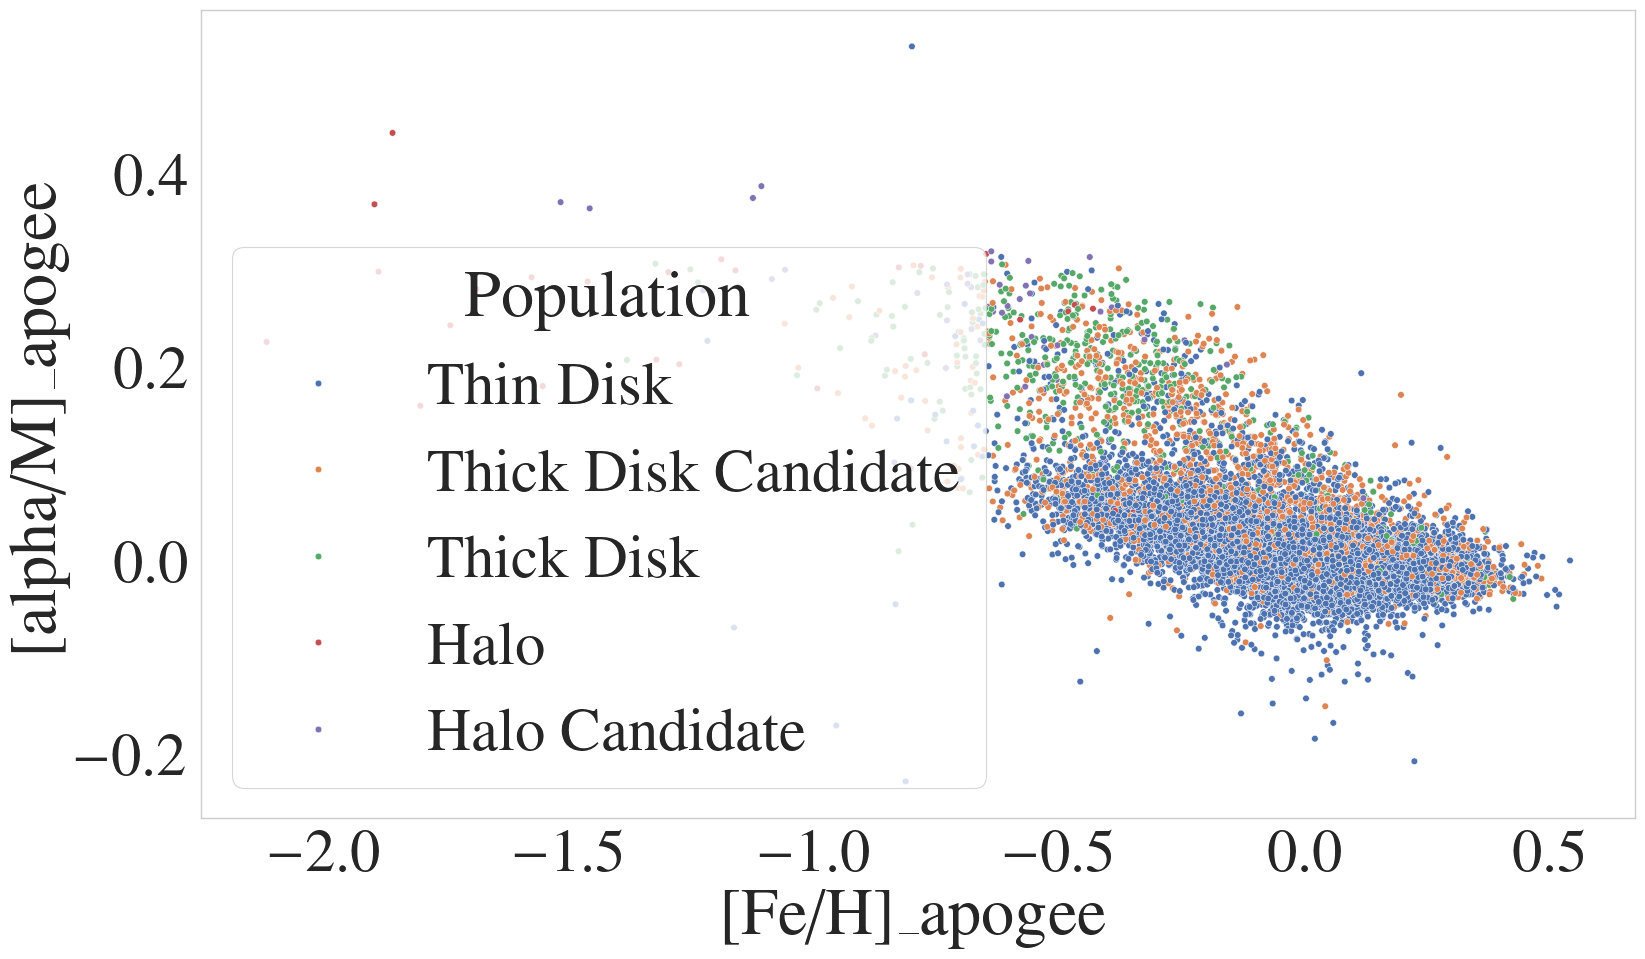

In [59]:
sns.scatterplot(
    data=data,
    x="[Fe/H]_apogee",
    y="[alpha/M]_apogee",
    hue="Population",
)